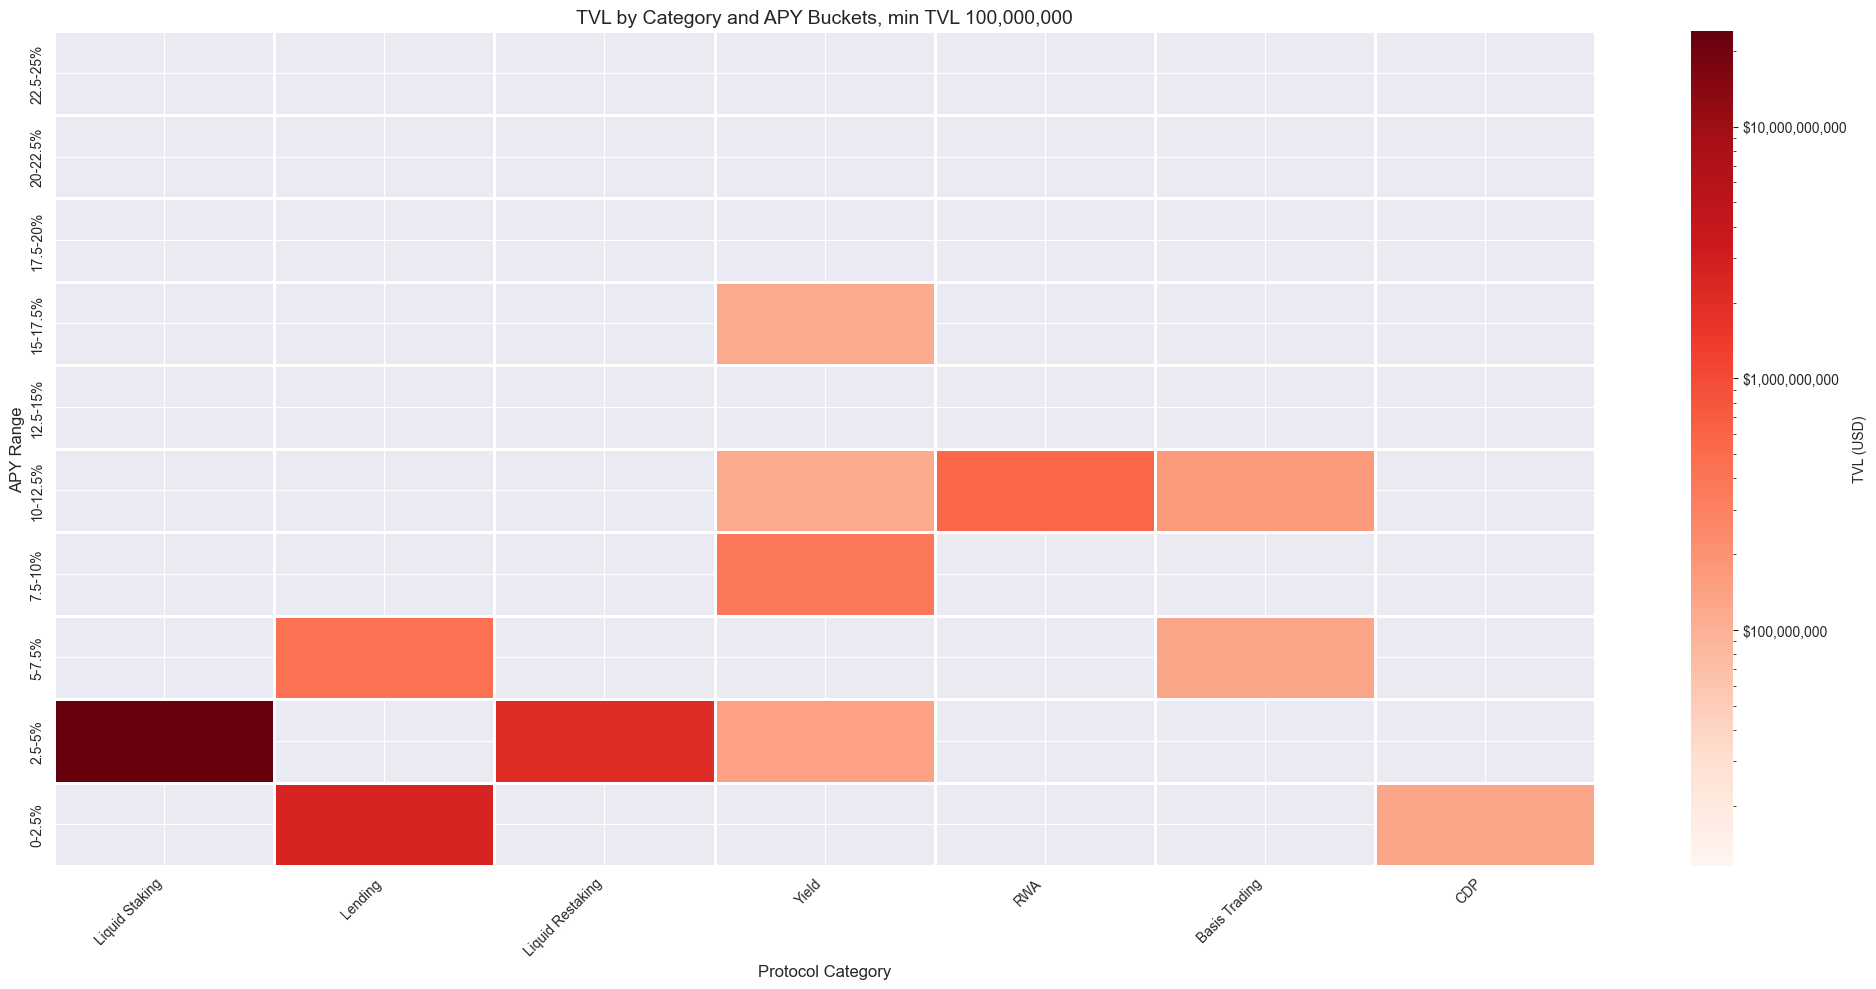

In [1]:
# Exploring the universe of data

from matplotlib import ticker
from matplotlib.colors import LogNorm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from main_app.infrastructure.market_data import get_enriched_pool_summary_data

tvl_min = 10e7

snapshot_df = get_enriched_pool_summary_data()

# Exclude 'None' category and NaN values
filtered_df = snapshot_df[(snapshot_df['protocol_category'] != 'None') &
                         (~snapshot_df['protocol_category'].isna()) &
                         (snapshot_df['tvl'] > tvl_min) &
                         (snapshot_df['chain'] == 'Ethereum')].copy()


# Define custom APY buckets with 5% increments
# Start at 0% and go up in 5% increments with a final bucket for outliers
custom_buckets = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
max_apy = filtered_df['apy'].max()

# Add a final bucket for outliers if needed
if max_apy > 25:
    custom_buckets.append(max_apy + 1)  # +1 to ensure all values are included

# Create bucket labels for display
bucket_labels = []
for i in range(len(custom_buckets) - 1):
    if i == len(custom_buckets) - 2 and max_apy > 50:
        bucket_labels.append(f">{custom_buckets[i]}%")
    else:
        bucket_labels.append(f"{custom_buckets[i]}-{custom_buckets[i+1]}%")

# Assign each APY value to a bucket
filtered_df['apy_bucket'] = pd.cut(
    filtered_df['apy'],
    bins=custom_buckets,
    labels=bucket_labels,
    include_lowest=True,
    right=False  # Intervals like [0,5), [5,10), etc.
)

# Calculate the sum of TVL for each (category, APY bucket) combination
heatmap_data = pd.crosstab(
    filtered_df['apy_bucket'],
    filtered_df['protocol_category'],
    values=filtered_df['tvl'],
    aggfunc='sum'  # Sum the TVL for protocols in each bucket
)

# Replace NaN values with 0
heatmap_data = heatmap_data.fillna(0)

# Sort categories by total TVL
category_tvl_totals = filtered_df.groupby('protocol_category')['tvl'].sum().sort_values(ascending=False)
heatmap_data = heatmap_data[category_tvl_totals.index]

# Sort the APY buckets in descending order (highest APY at the top)
heatmap_data = heatmap_data.sort_index(ascending=False)

# Create a figure with appropriate dimensions
plt.figure(figsize=(20, 10))  # Wider and taller to fit all buckets and categories

# Create the heatmap with logarithmic color scaling
# Add a small value to prevent log(0) issues
min_non_zero_tvl = heatmap_data[heatmap_data > 0].min().min()
v_min = min_non_zero_tvl * 0.1  # Set minimum value slightly below the lowest non-zero value

ax = sns.heatmap(
    heatmap_data,
    cmap="Reds",
    annot=False,  # Don't show values in grid cells
    norm=LogNorm(vmin=v_min),  # Use logarithmic scaling for colors
    linewidths=1,
    linecolor='white',
    cbar_kws={
        'label': 'TVL (USD)',
        'format': ticker.FuncFormatter(lambda x, p: f"${x:,.0f}")  # Format as full numbers with commas
    }
)

# Customize the plot
plt.title(f'TVL by Category and APY Buckets, min TVL {tvl_min:,.0f}', fontsize=14)
plt.xlabel('Protocol Category', fontsize=12)
plt.ylabel('APY Range', fontsize=12)

# Improve axis label visibility
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Format the colorbar with regular numbers instead of scientific notation
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Add more space at the bottom to accommodate the rotated labels
plt.subplots_adjust(bottom=0.3)

# Show the plot
plt.tight_layout()
plt.show()


Category mapping:
0: Basis Trading
1: CDP
2: Lending
3: Liquid Restaking
4: Liquid Staking
5: RWA
6: Yield

Model Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           6       1.00      1.00      1.00         1

    accuracy                           0.20         5
   macro avg       0.17      0.17      0.17         5
weighted avg       0.20      0.20      0.20         5


Feature Importance:
   Feature  Importance
1      apy    0.644444
0  log_tvl    0.355556


DECISION TREE LEAF NODES WITH ASSETS

Leaf Node 1: CDP [samples: 5]
Decision path:
  apy <= 1.28

Top projects in this leaf:
  - sparklend: 4 assets
  - crvusd: 1 assets

Sample assets in this leaf:
  - crvusd (504d25f6-9720-4bc3-bac3-3d4c

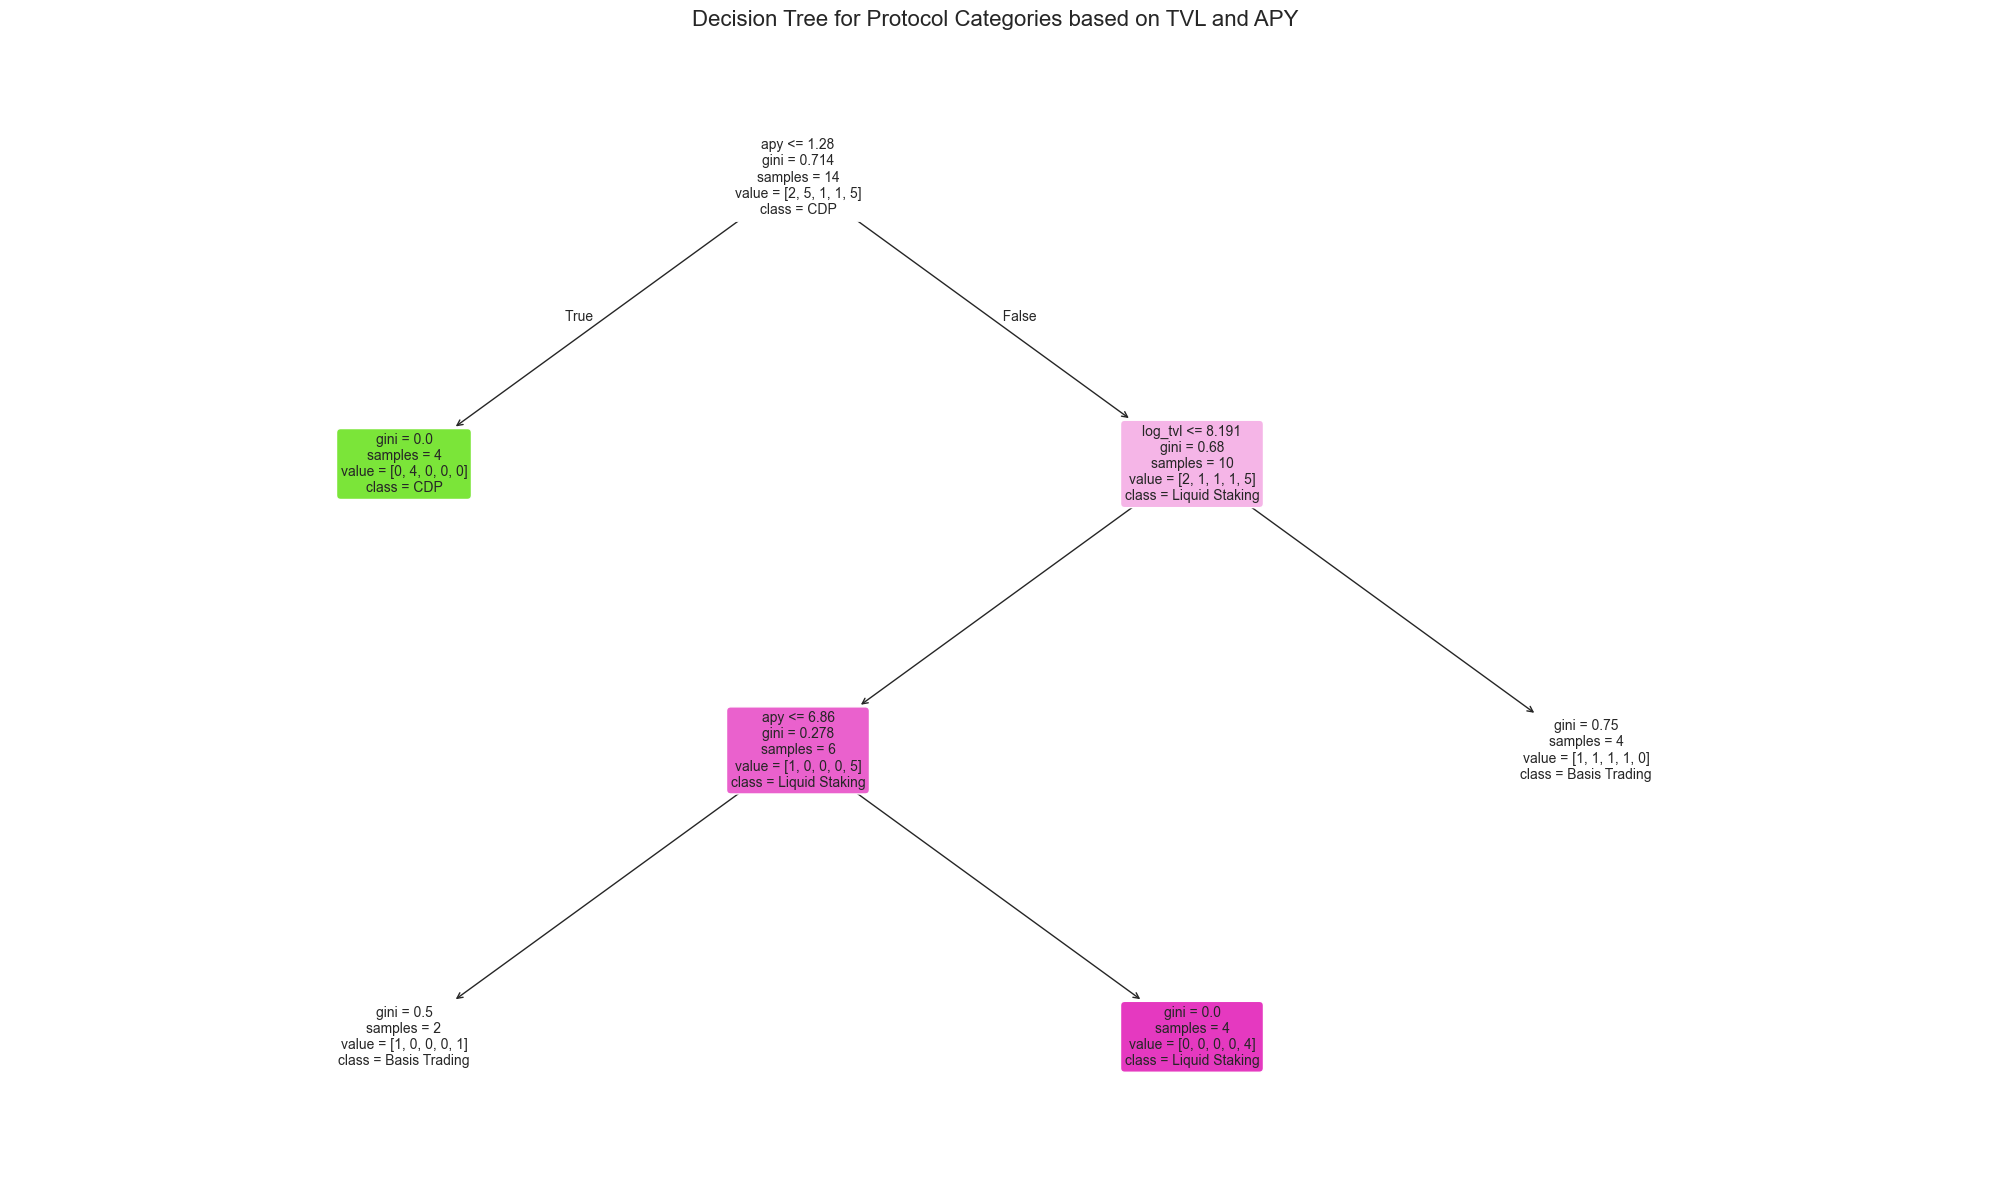

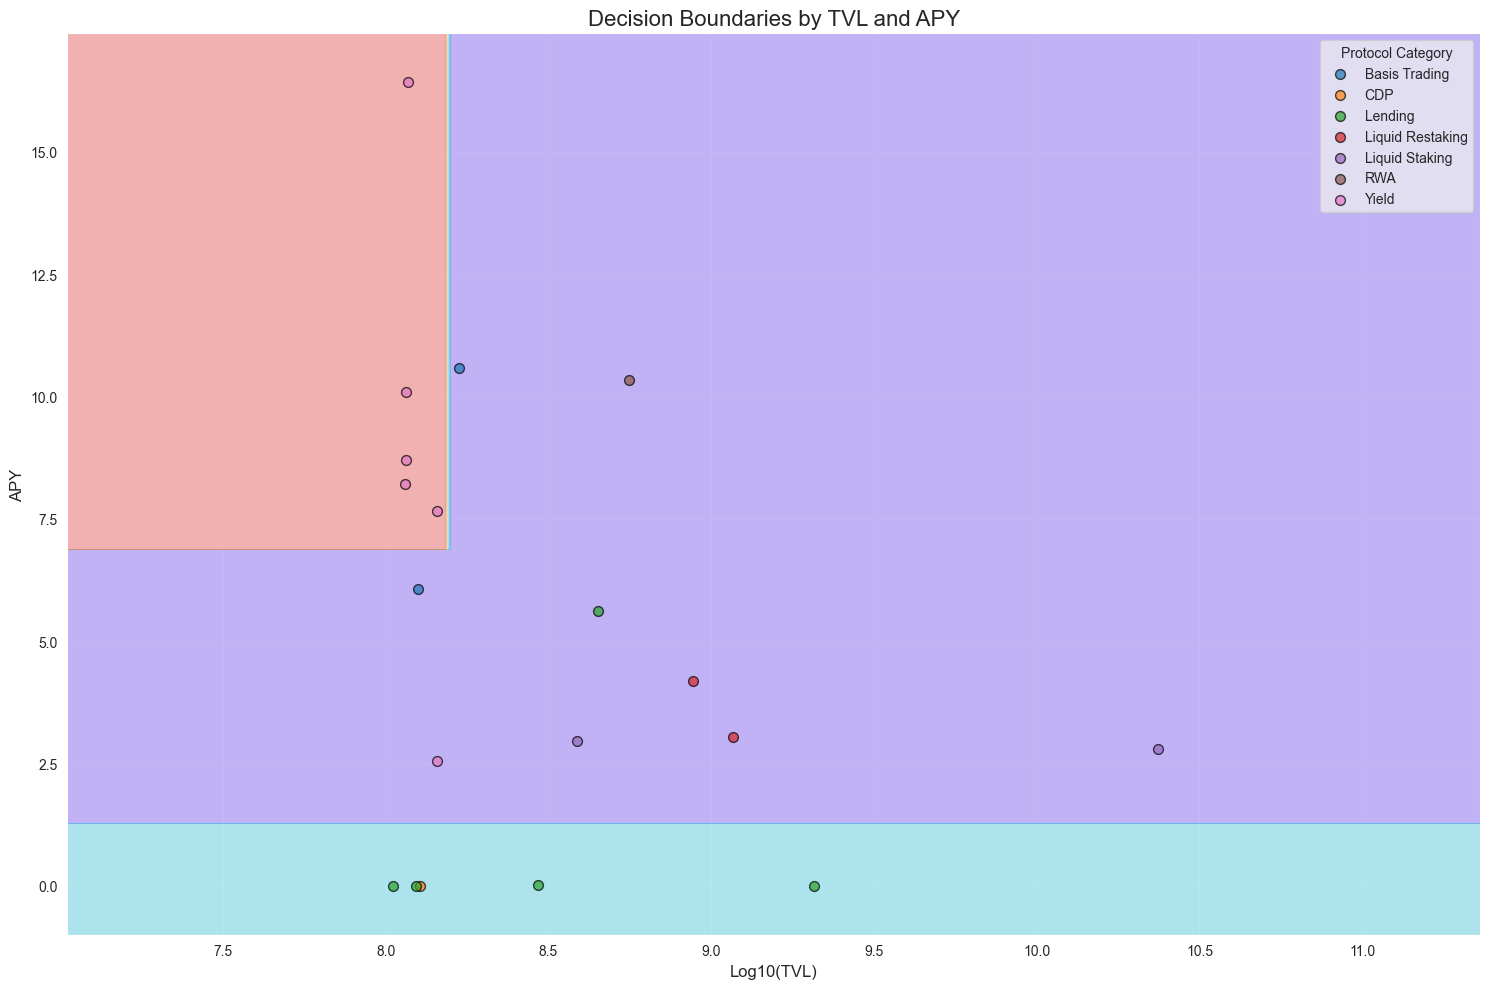

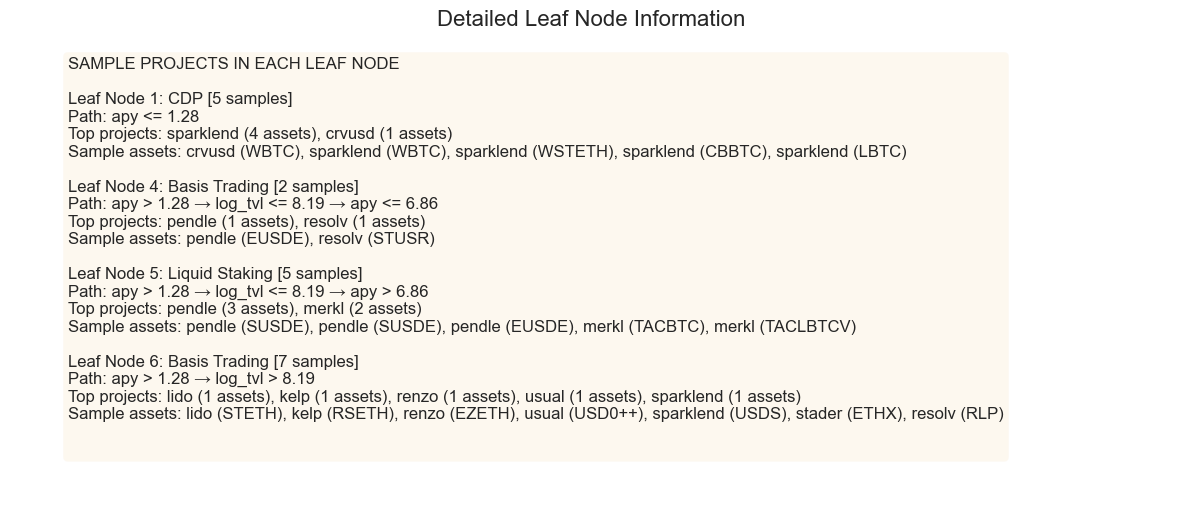

In [8]:
# Decision Tree using Ginu impurity

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming you already have your filtered_df from the previous code
# First, let's prepare the data for the decision tree

# Convert categorical protocol_category to numerical using LabelEncoder
label_encoder = LabelEncoder()
filtered_df['category_encoded'] = label_encoder.fit_transform(filtered_df['protocol_category'])

# Get the mapping from encoded values back to category names (for interpretation)
category_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("Category mapping:")
for code, category in category_mapping.items():
    print(f"{code}: {category}")

# Log-transform TVL to handle the wide range of values better
filtered_df['log_tvl'] = np.log10(filtered_df['tvl'] + 1)  # +1 to avoid log(0)

# Prepare features (TVL and APY) and target (protocol category)
X = filtered_df[['log_tvl', 'apy']].astype(np.float32)  # Explicitly convert to float32
y = filtered_df['category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create the decision tree classifier using Gini impurity
tree_model = DecisionTreeClassifier(
    criterion='gini',  # Use Gini impurity
    max_depth=4,       # Limit tree depth for better visualization
    min_samples_split=5,  # Minimum samples required to split an internal node
    random_state=42
)

# Train the model
tree_model.fit(X_train, y_train)

# Evaluate the model
y_pred = tree_model.predict(X_test)
print("\nModel Evaluation:")
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Direct approach: find the rules and assets under each node
tree = tree_model.tree_

# Get all leaves in the tree
leaf_nodes = np.where(tree.children_left == tree.children_right)[0]

# For each sample, determine which leaf it ends up in
leaf_for_samples = tree_model.apply(X)  # Use the original DataFrame with column names

# Create a map of leaf nodes to samples
leaf_to_samples = {}
for leaf in leaf_nodes:
    indices = np.where(leaf_for_samples == leaf)[0]
    leaf_to_samples[leaf] = indices

# Function to print decision path to a node
def print_path_to_node(tree, node_id, feature_names):
    """Print the decision path leading to a node."""
    path = []
    current = node_id

    # Start from the bottom and work up to the root
    def find_parent(tree, node_id, current_path):
        for i in range(tree.node_count):
            if tree.children_left[i] == node_id or tree.children_right[i] == node_id:
                if tree.children_left[i] == node_id:
                    condition = f"{feature_names[tree.feature[i]]} <= {tree.threshold[i]:.2f}"
                else:
                    condition = f"{feature_names[tree.feature[i]]} > {tree.threshold[i]:.2f}"
                return i, condition
        return -1, None

    # Trace path to root
    parent, condition = find_parent(tree, current, [])
    while parent != -1:
        path.append(condition)
        current = parent
        parent, condition = find_parent(tree, current, path)

    # Path is from root to node, so reverse it
    path.reverse()
    return path

# Function to print leaf information with path and assets
def print_leaf_info(leaf, feature_names, filtered_df, leaf_to_samples):
    """Print detailed information about a leaf node including decision path and assets."""
    # Get the path to this leaf
    path = print_path_to_node(tree, leaf, feature_names)

    # Get the predicted category
    predicted_class = np.argmax(tree.value[leaf])
    category = category_mapping[predicted_class]

    # Get samples in this leaf
    sample_indices = leaf_to_samples[leaf]
    leaf_samples = filtered_df.iloc[sample_indices]

    print(f"\nLeaf Node {leaf}: {category} [samples: {len(sample_indices)}]")
    print("Decision path:")
    for step in path:
        print(f"  {step}")

    # Top projects in this leaf
    print("\nTop projects in this leaf:")
    project_counts = leaf_samples['project'].value_counts().head(5)
    for project, count in project_counts.items():
        print(f"  - {project}: {count} assets")

    # Sample assets
    print("\nSample assets in this leaf:")
    for _, row in leaf_samples.head(min(5, len(leaf_samples))).iterrows():
        print(f"  - {row['project']} ({row['pool']}, {row['symbol']})")

    if len(leaf_samples) > 5:
        print(f"  ... and {len(leaf_samples) - 5} more assets")

    print("\n" + "-" * 50)

# Print information for each leaf
print("\n\n" + "=" * 60)
print("DECISION TREE LEAF NODES WITH ASSETS")
print("=" * 60)

for leaf in leaf_nodes:
    print_leaf_info(leaf, X.columns, filtered_df, leaf_to_samples)

# Create a visualization of the decision tree
plt.figure(figsize=(20, 12))
plot_tree(
    tree_model,
    feature_names=X.columns,
    class_names=[str(category_mapping[i]) for i in range(len(category_mapping))],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree for Protocol Categories based on TVL and APY', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/protocol_decision_tree.png', dpi=300)
plt.show()

# Create a scatter plot showing the decision boundaries
plt.figure(figsize=(15, 10))

# Create a mesh grid to visualize decision boundaries
h = 0.02  # Step size for mesh grid
x_min, x_max = X['log_tvl'].min() - 1, X['log_tvl'].max() + 1
y_min, y_max = X['apy'].min() - 1, X['apy'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Create a DataFrame with the same column names as your training data
mesh_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
mesh_df = pd.DataFrame(mesh_points, columns=X.columns)

# Predict classes using the DataFrame with proper column names
Z = tree_model.predict(mesh_df)
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3, cmap='rainbow')

# Plot the data points
for i, category in enumerate(np.unique(y)):
    idx = y == category
    plt.scatter(X.loc[idx, 'log_tvl'], X.loc[idx, 'apy'],  # Using .loc instead of .iloc with boolean mask
                label=category_mapping[i], alpha=0.7,
                edgecolor='black', s=50)

plt.xlabel('Log10(TVL)', fontsize=12)
plt.ylabel('APY', fontsize=12)
plt.title('Decision Boundaries by TVL and APY', fontsize=16)
plt.legend(title='Protocol Category')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/protocol_decision_boundaries.png', dpi=300)
plt.show()

# --------- Create a separate figure for sample information ---------
plt.figure(figsize=(15, len(leaf_nodes)*1.5))
plt.axis('off')

# Create a detailed description of each leaf node
text_content = "SAMPLE PROJECTS IN EACH LEAF NODE\n\n"
for leaf in leaf_nodes:
    # Get the path to this leaf
    path = print_path_to_node(tree, leaf, X.columns)

    # Get the predicted category
    predicted_class = np.argmax(tree.value[leaf])
    category = category_mapping[predicted_class]

    # Get samples in this leaf
    sample_indices = leaf_to_samples[leaf]
    leaf_samples = filtered_df.iloc[sample_indices]

    # Format the decision path
    path_str = " → ".join(path)

    # Get top projects
    top_projects = leaf_samples['project'].value_counts().head(5)
    projects_str = ", ".join([f"{p} ({c} assets)" for p, c in top_projects.items()])

    # Get sample assets
    sample_assets = []
    for _, row in leaf_samples.head(min(10, len(leaf_samples))).iterrows():
        sample_assets.append(f"{row['project']} ({row['symbol']})")

    if len(leaf_samples) > 10:
        sample_assets.append(f"...and {len(leaf_samples) - 10} more")

    sample_str = ", ".join(sample_assets)

    # Add information to text content
    text_content += f"Leaf Node {leaf}: {category} [{len(sample_indices)} samples]\n"
    text_content += f"Path: {path_str}\n"
    text_content += f"Top projects: {projects_str}\n"
    text_content += f"Sample assets: {sample_str}\n\n"

# Display the text on the figure
plt.text(0.05, 0.95, text_content, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))

plt.title('Detailed Leaf Node Information', fontsize=16)
plt.savefig('outputs/tree_sample_information.png', dpi=300)
plt.show()